In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.MixedMonotonicNet import MixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificates

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = NeuralNetRegressor(MixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6838        0.4345  8.5475
      2        0.3670        0.2912  7.7882
      3        0.3190        0.2858  7.9655
      4        0.2978        0.2891  7.5966
      5        0.2922        0.2831  7.5870
      6        0.2897        0.2816  7.7917
      7        0.2844        0.2785  7.4127
      8        0.2797        0.2744  7.6024
      9        0.2741        0.2684  7.3404
     10        0.2654        0.2599  7.5885
     11        0.2536        0.2472  7.5732
     12        0.2376        0.2302  7.3209
     13        0.2154        0.2041  7.4541
     14        0.1858        0.1751  7.4335
     15        0.1556        0.1513  7.3434
     16        0.1317        0.1379  7.3904
     17        0.1152        0.1318  7.4605
     18        0.1037        0.1292  7.4039
     19        0.0951        0.1283  7.4158
     20        0.0894        0.1274  7.6323
     21        0.0866        0.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MixedNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32, out_fea

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

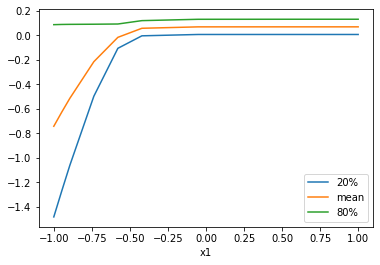

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [21]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

Now train orthonormal certificates.  Note, including raw numeric features helps quality.

In [24]:
oc = OrthonormalCertificates()
oc.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

Create another PDP like dataset with the full range.

In [31]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

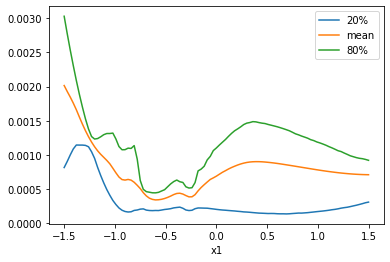

In [32]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.